In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import torch
import torch.optim
# CODE FILES HERE
from examples.vae.vae import Encoder, Decoder, Vae, PATH
from solver import Solver
from dataloader import DataLoader
from plot import plot_losses, plot_gauss_distributions, plot_rl_kl, plot_latent_space, plot_latent_manifold, plot_faces, plot_faces_grid

%matplotlib inline
#plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
#plt.rcParams['image.interpolation'] = 'nearest'
#plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

# supress cluttering warnings in solutions
import warnings
warnings.filterwarnings('ignore')

In [2]:
# setting device on GPU if available, else CPU
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)
print()

#Additional Info when using cuda
if device.type == 'cuda':
    print(torch.cuda.get_device_name(0))
    print('Memory Usage:')
    print('Allocated:', round(torch.cuda.memory_allocated(0)/1024**3,1), 'GB')
    print('Cached:   ', round(torch.cuda.memory_cached(0)/1024**3,1), 'GB')

Using device: cpu



In [3]:
batch_size = 128
optimizer = torch.optim.Adam

In [36]:
dataset = "LFW"
if dataset == "MNIST" or dataset == "EMNIST":
    epochs = 8
    h = 28
    w = 28
    img_dims = (h, w)
    input_dim = np.prod((h, w))
    hidden_dim = 500 # Kingma, Welling use 500 neurons, otherwise use 400
    z_dim = 2 # 1000 is suggested in the paper "Tutorial on VAE" but Kingma, Welling show 20 is sufficient for MNIST
    optim_config = {
        "lr": 1e-3,
        "weight_decay": 0
    }
elif dataset == "LFW":
    epochs = 8
    h = 50
    w = 37
    img_dims = (h, w)
    input_dim = np.prod((h, w))
    hidden_dim = 600 # TODO: 1200? 200 in Kingma for Frey Face but highly varying data!
    z_dim = 20
    step_config = {
        "step_size" : 50,
        "gamma" : 0.1
    }
    optim_config = {
        "lr": 1e-2,
        "weight_decay": 1e-4
    }

In [37]:
encoder = Encoder(input_dim, hidden_dim, z_dim)
decoder = Decoder(z_dim, hidden_dim, input_dim)
model = Vae(encoder, decoder)

In [38]:
data_loader = DataLoader(PATH, batch_size, dataset, z_dim)
solver = Solver(model, data_loader, optimizer, z_dim, (h, w), epochs, step_config, optim_config)
solver.run()

+++++ START RUN +++++
====> Epoch: 1 train set loss avg: 187.1203
====> Test set loss avg: 180.4293
38.01074981689453 seconds for epoch 1


KeyboardInterrupt: 

In [22]:
last_train_loss = list(list(zip(*solver.train_loss_history))[1])[-1]
torch.save(solver, "../models/VAE_" + dataset + "_train_loss=" + "{0:.2f}".format(last_train_loss) + "_z=" + str(z_dim) + ".pt")

PicklingError: Can't pickle <class 'solver.Solver'>: it's not the same object as solver.Solver

In [36]:
# Insert name of model here
#solver = torch.load("../models/VAE_MNIST_train_loss=151.39_z=2.pt")

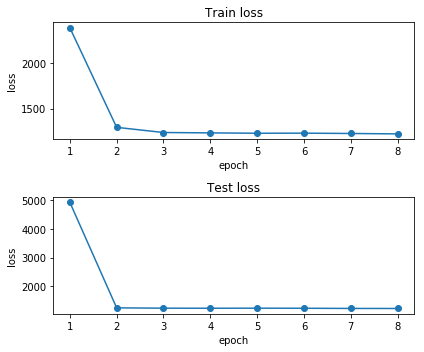

In [34]:
# Plotting train and test losses for all epochs
train_loss_history = list(list(zip(*solver.train_loss_history))[1])
plot_losses(solver, train_loss_history, solver.test_loss_history)

epoch: 2, mu(z): -0.0509, stddev(z): 1.3137, var(z): 1.7258, var(mu(z)): 0.1199 E[var(q(z|x)]: 0.3939
epoch: 4, mu(z): -0.0629, stddev(z): 1.0933, var(z): 1.1952, var(mu(z)): 0.1316 E[var(q(z|x)]: 0.5479
epoch: 6, mu(z): -0.0712, stddev(z): 1.0956, var(z): 1.2003, var(mu(z)): 0.1510 E[var(q(z|x)]: 0.6077
epoch: 8, mu(z): -0.0773, stddev(z): 1.0816, var(z): 1.1700, var(mu(z)): 0.2297 E[var(q(z|x)]: 0.4806


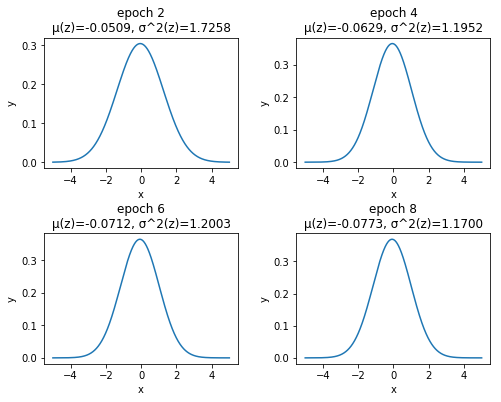

In [35]:
# Plotting histogram of the latent space's distribution, given the computed \mu and \sigma
num_plots = 4
if (num_plots % 4) == 0:
    plot_gauss_distributions(solver, num_plots)

epoch: 1, train_loss: 188.37, test_loss: 181.66, recon. loss: 183.17, KL div.: 5.20
overfitting: 6.71
epoch: 2, train_loss: 165.52, test_loss: 178.29, recon. loss: 160.34, KL div.: 5.19
overfitting: 12.77
epoch: 3, train_loss: 161.06, test_loss: 176.60, recon. loss: 155.64, KL div.: 5.42
overfitting: 15.54
epoch: 4, train_loss: 158.74, test_loss: 176.79, recon. loss: 153.19, KL div.: 5.55
overfitting: 18.05
epoch: 5, train_loss: 157.09, test_loss: 176.15, recon. loss: 151.45, KL div.: 5.64
overfitting: 19.07
epoch: 6, train_loss: 155.73, test_loss: 178.71, recon. loss: 150.03, KL div.: 5.70
overfitting: 22.97
epoch: 7, train_loss: 154.64, test_loss: 175.77, recon. loss: 148.89, KL div.: 5.76
overfitting: 21.13
epoch: 8, train_loss: 153.71, test_loss: 175.22, recon. loss: 147.90, KL div.: 5.81
overfitting: 21.51


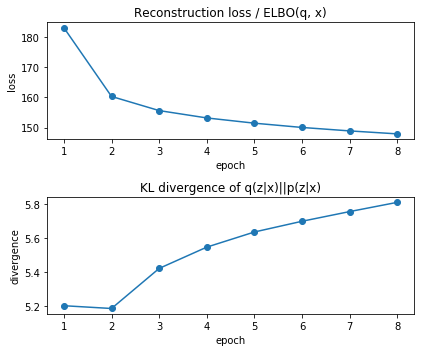

In [39]:
# Monitoring the reconstruction loss (likelihood lower bound) and KL divergence
rls = list(list(zip(*solver.train_loss_history))[2])
kls = list(list(zip(*solver.train_loss_history))[3])
for ((epoch, train_loss, rl, kl), test_loss) in zip(solver.train_loss_history, solver.test_loss_history):
    print("epoch: {}, train_loss: {:.2f}, test_loss: {:.2f}, recon. loss: {:.2f}, KL div.: {:.2f}".format(epoch, train_loss, test_loss, rl, kl))
    print("overfitting: {:.2f}".format(abs(test_loss-train_loss)))
plot_rl_kl(solver, rls, kls)

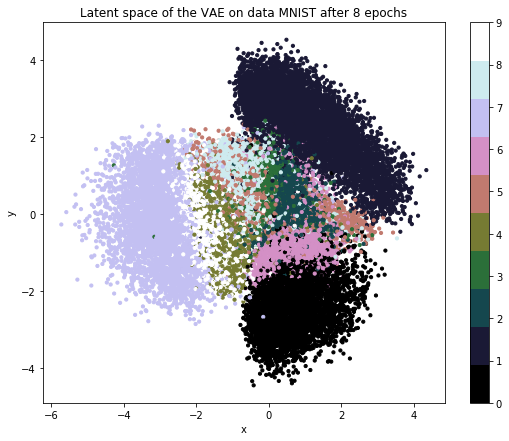

In [41]:
# visualize q(z|x) (latent space z)
if solver.z_dim == 2:
    plot_latent_space(solver)
else:
    print("Plot of latent space not possible as dimension of z is not 2")

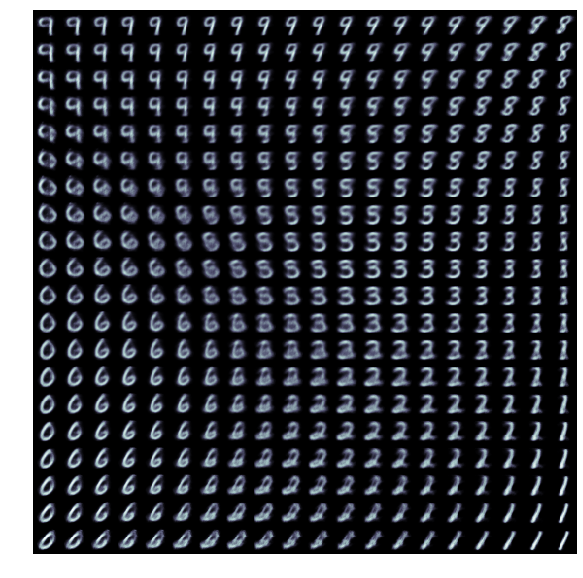

In [42]:
# Visualizations of learned data manifold for generative models with two-dimensional latent space
if solver.z_dim == 2:
    if solver.loader.dataset == "MNIST":
        plot_latent_manifold(solver, "bone")
    if solver.loader.dataset == "LFW":
        plot_latent_manifold(solver, "gray", n=10, fig_size=(8,6))
else:
    print("Plot is not possible as dimension of z is not 2")

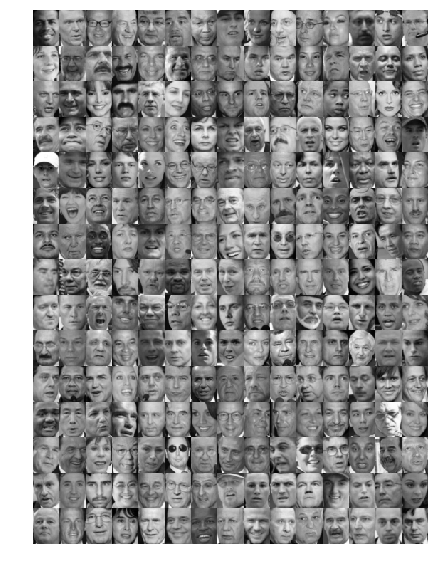

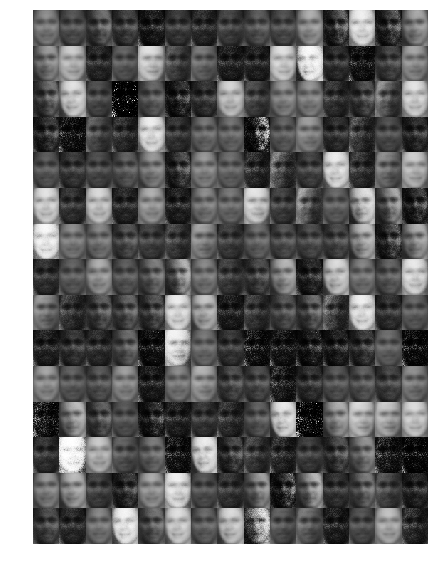

In [140]:
if dataset == "LFW":
    plot_faces(225, 15, solver)
    plot_faces_grid(225, 15, solver)